# 01 — Data Collection

This notebook collects all primary datasets for the analysis:
- Brewery data from the OpenBreweryDB API  
- ACS 5-year estimates for median home value in Philadelphia  
- Census tract geometries  
- Philadelphia street network from OpenStreetMap via OSMnx  

All data is saved to the `data/raw/` directory for reproducibility.

## Setup  
Load packages and custom module functions.  
Load the Census API key from the environment (ensuring it is not hardcoded).

In [1]:
import sys
sys.path.append("../src")

import os
import pandas as pd
import geopandas as gpd
import osmnx as ox

# Custom modules
from data_breweries import fetch_breweries_by_city, breweries_to_geodataframe
from data_acs import load_acs_philly, load_philly_tract_shapes
from data_osm import load_walk_network

API_KEY = os.getenv("CENSUS_API_KEY")
API_KEY

## Brewery Data Collection (OpenBreweryDB API)

Pull all breweries located in Philadelphia using the `by_city` parameter.  
After pulling, convert the results into a GeoDataFrame and save them as raw data in the repo


In [2]:
# Fetch brewery data
df_brew = fetch_breweries_by_city("philadelphia")
df_brew.head()


,id,name,brewery_type,address_1,address_2,address_3,city,state_province,postal_code,country,longitude,latitude,phone,website_url,state,street
0,fb8eee34-da8a-42b2-bc4c-77020024a7f0,2nd Story Brewing Company,brewpub,117 Chestnut St Frnt,None,None,Philadelphia,Pennsylvania,19106-4700,United States,NaN,NaN,2673145770,http://www.2ndstorybrewing.com/,Pennsylvania,117 Chestnut St Frnt
1,87d71c35-9537-4ef1-b232-668bea736ffa,Attic Brewing,planning,None,None,None,Philadelphia,Pennsylvania,19144-3603,United States,NaN,NaN,7082047376,None,Pennsylvania,None
2,a834c4b5-4852-4887-aa6f-c872dfc10824,Bar Hygge / Brewery Techne,brewpub,1720 Fairmount Ave,None,None,Philadelphia,Pennsylvania,19130-2858,United States,-75.165673,39.967073,None,None,Pennsylvania,1720 Fairmount Ave
3,6b04fb31-0531-49fc-8dbf-517138e6c1dd,Brewery ARS,micro,1927-29 W Passyunk Ave,None,None,Philadelphia,Pennsylvania,19145-3620,United States,NaN,NaN,2159605173,http://breweryars.com,Pennsylvania,1927-29 W Passyunk Ave
4,6660d8a1-2668-4096-9510-92ea23e6371e,Crime & Punishment Brewing Company,brewpub,2711 W Girard Ave,None,None,Philadelphia,Pennsylvania,19130-1212,United States,-75.180842,39.974365,2152352739,http://www.crimeandpunishmentbrewery.com,Pennsylvania,2711 W Girard Ave


In [3]:
# Convert to GeoDataFrame
gdf_brew = breweries_to_geodataframe(df_brew)
gdf_brew.head()


,id,name,brewery_type,address_1,address_2,address_3,city,state_province,postal_code,country,longitude,latitude,phone,website_url,state,street,geometry
2,a834c4b5-4852-4887-aa6f-c872dfc10824,Bar Hygge / Brewery Techne,brewpub,1720 Fairmount Ave,None,None,Philadelphia,Pennsylvania,19130-2858,United States,-75.165673,39.967073,None,None,Pennsylvania,1720 Fairmount Ave,POINT (-75.16567 39.96707)
4,6660d8a1-2668-4096-9510-92ea23e6371e,Crime & Punishment Brewing Company,brewpub,2711 W Girard Ave,None,None,Philadelphia,Pennsylvania,19130-1212,United States,-75.180842,39.974365,2152352739,http://www.crimeandpunishmentbrewery.com,Pennsylvania,2711 W Girard Ave,POINT (-75.18084 39.97436)
7,18b29afa-682c-4c5e-8ecb-ba0f61cf9f16,Earth Bread + Brewery,brewpub,7136 Germantown Ave,None,None,Philadelphia,Pennsylvania,19119-1843,United States,-75.190355,40.059200,2152426666,http://www.earthbreadbrewery.com,Pennsylvania,7136 Germantown Ave,POINT (-75.19035 40.05920)
8,339caa7a-481f-4315-bba1-bca6b74d8b89,Evil Genius Beer Co,micro,1727 N Front St,None,None,Philadelphia,Pennsylvania,19122-3203,United States,-75.134016,39.975780,2154256820,http://www.evilgeniusbeer.com,Pennsylvania,1727 N Front St,POINT (-75.13402 39.97578)
9,e8f67941-37fa-41bd-8c4b-ca598a144217,Fermentery Form,micro,161 Cecil B Moore Ave,None,None,Philadelphia,Pennsylvania,19122-3234,United States,-75.136886,39.976092,2675183676,http://www.fermenteryform.com,Pennsylvania,161 Cecil B Moore Ave,POINT (-75.13689 39.97609)


In [4]:
# Save raw brewery data
gdf_brew.to_file("../data/raw/breweries_philly.geojson", driver="GeoJSON")

<Axes: >

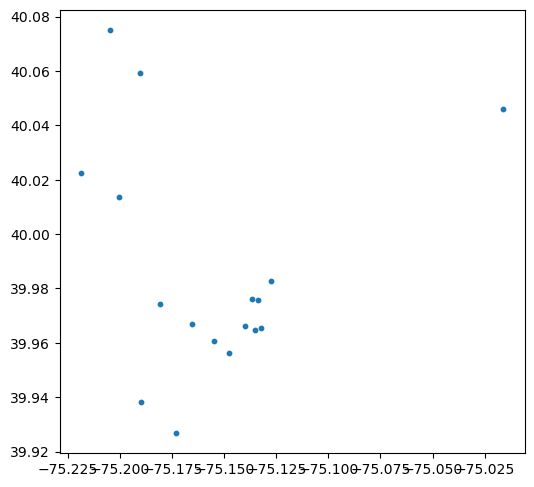

In [5]:
gdf_brew.plot(figsize=(6,6), markersize=10)

## ACS Median Home Value + Tract Boundaries

Retrieve median home value (`B25077_001E`) from the ACS 5-year dataset for all census tracts in Philadelphia County. Download tract geometries via TIGER/Line files.


In [6]:
# Load ACS median home value for Philadelphia tracts
df_acs = load_acs_philly(API_KEY)
df_acs.head()

,NAME,median_home_value,state,county,tract,GEOID
0,Census Tract 1.01; Philadelphia County; Pennsy...,511400.0,42,101,000101,42101000101
1,Census Tract 1.02; Philadelphia County; Pennsy...,508100.0,42,101,000102,42101000102
2,Census Tract 2; Philadelphia County; Pennsylvania,483700.0,42,101,000200,42101000200
3,Census Tract 3; Philadelphia County; Pennsylvania,669800.0,42,101,000300,42101000300
4,Census Tract 4.01; Philadelphia County; Pennsy...,587400.0,42,101,000401,42101000401


In [7]:
from data_acs import load_philly_tract_shapes

gdf_tracts = load_philly_tract_shapes(2022)
gdf_tracts.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
98,42,101,026301,42101026301,263.01,Census Tract 263.01,G5020,S,406340,0,+40.0728148,-075.1637161,"POLYGON ((-75.16899 40.07147, -75.16864 40.071..."
99,42,101,029200,42101029200,292,Census Tract 292,G5020,S,1745920,28444,+40.0249035,-075.1017831,"POLYGON ((-75.11288 40.02746, -75.11280 40.027..."
100,42,101,024400,42101024400,244,Census Tract 244,G5020,S,421189,0,+40.0248284,-075.1638925,"POLYGON ((-75.16912 40.02387, -75.16843 40.024..."
101,42,101,033200,42101033200,332,Census Tract 332,G5020,S,842716,0,+40.0439733,-075.0449684,"POLYGON ((-75.05465 40.04465, -75.05396 40.045..."
102,42,101,980200,42101980200,9802,Census Tract 9802,G5020,S,4916641,250846,+40.0712811,-075.0443487,"POLYGON ((-75.07448 40.08685, -75.07443 40.087..."


In [8]:
df_acs.to_csv("../data/raw/acs_philly_median_home_value.csv", index=False)
gdf_tracts.to_file("../data/raw/tracts_philly.geojson", driver="GeoJSON")

## Philadelphia Street Network (OSMnx)

Download the walkable street network for Philadelphia using OSMnx. This will be used later to compute walking distances and brewery accessibility.

In [9]:
G = load_walk_network()
G

In [10]:
ox.save_graphml(G, "../data/raw/philly_walk_network.graphml")

## Visual Checks

Before moving to the next step, confirm that:
- Brewery points fall inside Philadelphia  
- Tracts load correctly  
- CRS matches expectations (EPSG:4326 for ACS/breweries)


<Axes: >

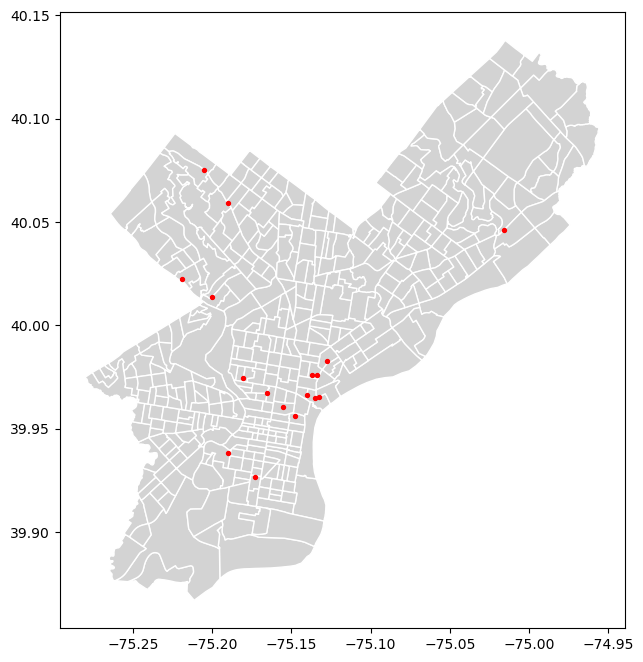

In [11]:
ax = gdf_tracts.plot(figsize=(8,8), color="lightgrey", edgecolor="white")
gdf_brew.plot(ax=ax, color="red", markersize=8)

# Summary

In this notebook, we successfully collected:

- Philadelphia brewery locations (OpenBreweryDB API)  
- ACS 5-year median home value estimates  
- Census tract geometries  
- The walkable street network for Philadelphia (OSMnx)

All datasets are saved in `data/raw/` and are ready for cleaning  
and feature engineering in **Notebook 2**.
